In [1]:
#COMET ML API KEY YarDlAXZLHepLKBFlSPyWbDPt
import comet_ml
comet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")
from comet_ml import Experiment
experiment = Experiment(
    api_key="YarDlAXZLHepLKBFlSPyWbDPt",
    project_name="atp-simplified-classification",
    workspace="mattbeze",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)

Saving config to "C:\Users\mattbeze\.comet.config"... done!


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mattbeze/atp-simplified-classification/88d71d1e91fd45139c3f137d8739b2c0



In [2]:
import numpy as np
import seaborn as sn
from imblearn.over_sampling import SMOTE 
import keras
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
#Extra features that are available: Sex, Gestational Age 

#22 1s Atypicals defined as having an attention problem t-score >= 65 in BASC2 6year
#115 0s

Using TensorFlow backend.


In [3]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP Middle'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(129, 298)
(129, 1)


In [4]:
data_features = data_features.to_numpy()
labels = labels.to_numpy()

skf = StratifiedKFold(n_splits=8, random_state=seed_value)
skf.get_n_splits(data_features, labels)
print(skf)

training_folds_X = []
testing_folds_X = []
training_folds_Y = []
testing_folds_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features[train_index], data_features[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    
    training_folds_X.append(X_train_smoted)
    testing_folds_X.append(X_test)
    training_folds_Y.append(Y_train_smoted)
    testing_folds_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=7, shuffle=False)


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [5]:
def create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7):
    predictions = []
    true = []
    
    for i in range(0,p0.size):
        if p0[i] == 0:
            predictions.append(0)
        if p0[i] == 1:
            predictions.append(1)
        if t0[i] == 0:
            true.append(0)
        if t0[i] == 1:
            true.append(1)
    for i in range(0,p1.size):
        if p1[i] == 0:
            predictions.append(0)
        if p1[i] == 1:
            predictions.append(1)
        if t1[i] == 0:
            true.append(0)
        if t1[i] == 1:
            true.append(1)
    for i in range(0,p2.size):
        if p2[i] == 0:
            predictions.append(0)
        if p2[i] == 1:
            predictions.append(1)
        if t2[i] == 0:
            true.append(0)
        if t2[i] == 1:
            true.append(1)
    for i in range(0,p3.size):
        if p3[i] == 0:
            predictions.append(0)
        if p3[i] == 1:
            predictions.append(1)
        if t3[i] == 0:
            true.append(0)
        if t3[i] == 1:
            true.append(1)
    for i in range(0,p4.size):
        if p4[i] == 0:
            predictions.append(0)
        if p4[i] == 1:
            predictions.append(1)
        if t4[i] == 0:
            true.append(0)
        if t4[i] == 1:
            true.append(1)
    for i in range(0,p5.size):
        if p5[i] == 0:
            predictions.append(0)
        if p5[i] == 1:
            predictions.append(1)
        if t5[i] == 0:
            true.append(0)
        if t5[i] == 1:
            true.append(1)
    for i in range(0,p6.size):
        if p6[i] == 0:
            predictions.append(0)
        if p6[i] == 1:
            predictions.append(1)
        if t6[i] == 0:
            true.append(0)
        if t6[i] == 1:
            true.append(1)
    for i in range(0,p7.size):
        if p7[i] == 0:
            predictions.append(0)
        if p7[i] == 1:
            predictions.append(1)
        if t7[i] == 0:
            true.append(0)
        if t7[i] == 1:
            true.append(1)
    
    
    prec_score = precision_score(true, predictions, average=None)
    print('Positive Predictive Value tp/(tp+fp): ',prec_score[1])
    
    rec_score = recall_score(true, predictions, average=None)
    print('Recall Value tp/(tp+fn): ',rec_score[1])
    
    cf_matrix = confusion_matrix(true, predictions)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    

In [6]:
#Best: 0.497768 using {'batch_size': 35, 'dropout': 0.3, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 20}
def run_model(n):
    predictor = keras.models.load_model('ASD Pre_Trained Model for ATP Simplified') #Model with ASD Pre-training

    class_weights={0:1, 1:4} 
    
    p = predictor.fit(training_folds_X[n], training_folds_Y[n],
    epochs=100,
    batch_size=35,
    shuffle=True,
    validation_data=(testing_folds_X[n], testing_folds_Y[n]), class_weight=class_weights)

    #Plotting loss
    plt.plot(p.history['loss'])
    plt.plot(p.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.axis([0, 100, 0.0, 1.10])
    plt.show()

    #Plotting Accuracy
    plt.plot(p.history['acc'])
    plt.plot(p.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.axis([0, 100, 0.0, 1.05])
    plt.show()
    
    
    predictions = predictor.predict(testing_folds_X[n])
    predicted_classes = (predictions > 0.5).astype(int)

    #Heatmap for the confusion matrix
    cf_matrix = confusion_matrix(testing_folds_Y[n], predicted_classes)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    average_precision = average_precision_score(predicted_classes, testing_folds_Y[n])

    
    prec_score = precision_score(testing_folds_Y[n], predicted_classes, average=None)
    print('PPV: ',prec_score[1])
    
    rec_score = recall_score(testing_folds_Y[n], predicted_classes, average=None)
    print('Recall: ',rec_score[1])

    
    return predicted_classes, testing_folds_Y[n]

In [ ]:
p0, t0 = run_model(0)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET INFO: Ignoring automatic log_parameter('do_validation') because 'keras:do_validation' is in COMET_LOGGING_PARAMETERS_IGNORE


Train on 186 samples, validate on 17 samples
Epoch 1/100
 35/186 [====>.........................] - ETA: 3:10 - loss: 9.9003 - acc: 0.4000

COMET INFO: Ignoring automatic log_metric('batch_batch') because 'keras:batch_batch' is in COMET_LOGGING_METRICS_IGNORE
COMET INFO: Ignoring automatic log_metric('batch_size') because 'keras:batch_size' is in COMET_LOGGING_METRICS_IGNORE


186/186 [==============================] - 45s 242ms/step - loss: 3.7183 - acc: 0.5215 - val_loss: 3.0720 - val_acc: 0.1765
Epoch 2/100
186/186 [==============================] - 0s 977us/step - loss: 1.5217 - acc: 0.5000 - val_loss: 1.0114 - val_acc: 0.1765
Epoch 3/100
186/186 [==============================] - 0s 2ms/step - loss: 1.2239 - acc: 0.5430 - val_loss: 1.5841 - val_acc: 0.1765
Epoch 4/100
186/186 [==============================] - 0s 2ms/step - loss: 1.3193 - acc: 0.4946 - val_loss: 1.0479 - val_acc: 0.1765
Epoch 5/100
186/186 [==============================] - 0s 959us/step - loss: 1.1806 - acc: 0.5161 - val_loss: 1.1085 - val_acc: 0.1765
Epoch 6/100
186/186 [==============================] - 0s 1ms/step - loss: 1.1455 - acc: 0.5054 - val_loss: 1.1556 - val_acc: 0.1765
Epoch 7/100
186/186 [==============================] - 0s 957us/step - loss: 1.1923 - acc: 0.5108 - val_loss: 1.1723 - val_acc: 0.1765
Epoch 8/100
186/186 [==============================] - 0s 1ms/step - los

C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125688). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


Epoch 59/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0259 - acc: 1.0000 - val_loss: 0.3734 - val_acc: 0.8235
Epoch 60/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0547 - acc: 0.9839 - val_loss: 0.4121 - val_acc: 0.8235
Epoch 61/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0558 - acc: 0.9892 - val_loss: 0.3829 - val_acc: 0.8235
Epoch 62/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0242 - acc: 1.0000 - val_loss: 0.3342 - val_acc: 0.8235
Epoch 63/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0444 - acc: 0.9839 - val_loss: 0.3299 - val_acc: 0.8235
Epoch 64/100
186/186 [==============================] - 0s 920us/step - loss: 0.0246 - acc: 0.9946 - val_loss: 0.3458 - val_acc: 0.8235
Epoch 65/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.3418 - val_acc: 0.8235
Epoch 66/100
186/186 [==============================] - 0s 2

Epoch 80/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0218 - acc: 1.0000 - val_loss: 1.1128 - val_acc: 0.8125
Epoch 81/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0203 - acc: 0.9946 - val_loss: 1.0954 - val_acc: 0.8750
Epoch 82/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0071 - acc: 1.0000 - val_loss: 1.1011 - val_acc: 0.8750
Epoch 83/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0239 - acc: 0.9946 - val_loss: 1.1317 - val_acc: 0.8750
Epoch 84/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0298 - acc: 0.9946 - val_loss: 1.1043 - val_acc: 0.8750
Epoch 85/100
186/186 [==============================] - 0s 1ms/step - loss: 0.0241 - acc: 0.9946 - val_loss: 1.1051 - val_acc: 0.8750
Epoch 86/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0091 - acc: 1.0000 - val_loss: 1.1354 - val_acc: 0.8750
Epoch 87/100
186/186 [==============================] - 0s 2ms

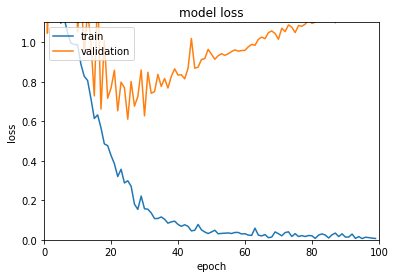

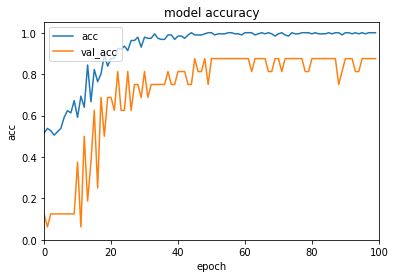

[[14  0]
 [ 2  0]]


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV:  0.0
Recall:  0.0


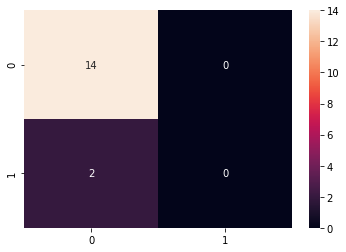

In [8]:
p1, t1 = run_model(1)

Train on 186 samples, validate on 16 samples
Epoch 1/100
186/186 [==============================] - 6s 33ms/step - loss: 3.5316 - acc: 0.5323 - val_loss: 3.7367 - val_acc: 0.1250
Epoch 2/100
186/186 [==============================] - 0s 1ms/step - loss: 1.5925 - acc: 0.5000 - val_loss: 0.6735 - val_acc: 0.6250
Epoch 3/100
186/186 [==============================] - 0s 1ms/step - loss: 1.3754 - acc: 0.5484 - val_loss: 1.1234 - val_acc: 0.1250
Epoch 4/100
186/186 [==============================] - 0s 2ms/step - loss: 1.2451 - acc: 0.5054 - val_loss: 1.3997 - val_acc: 0.1250
Epoch 5/100
186/186 [==============================] - 0s 2ms/step - loss: 1.1760 - acc: 0.5054 - val_loss: 1.0587 - val_acc: 0.1250
Epoch 6/100
186/186 [==============================] - 0s 1ms/step - loss: 1.2714 - acc: 0.5108 - val_loss: 1.0450 - val_acc: 0.1250
Epoch 7/100
186/186 [==============================] - 0s 1ms/step - loss: 1.1866 - acc: 0.5108 - val_loss: 1.2043 - val_acc: 0.1250
Epoch 8/100
186/186 [==

Epoch 62/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0318 - acc: 0.9946 - val_loss: 1.1103 - val_acc: 0.8125
Epoch 63/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0200 - acc: 1.0000 - val_loss: 1.1075 - val_acc: 0.8125
Epoch 64/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0413 - acc: 0.9892 - val_loss: 1.1585 - val_acc: 0.8750
Epoch 65/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0241 - acc: 1.0000 - val_loss: 1.1698 - val_acc: 0.8750
Epoch 66/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0247 - acc: 1.0000 - val_loss: 1.2134 - val_acc: 0.8125
Epoch 67/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0207 - acc: 0.9946 - val_loss: 1.2402 - val_acc: 0.8125
Epoch 68/100
186/186 [==============================] - 0s 2ms/step - loss: 0.0345 - acc: 0.9892 - val_loss: 1.2631 - val_acc: 0.8125
Epoch 69/100
186/186 [==============================] - 0s 2ms

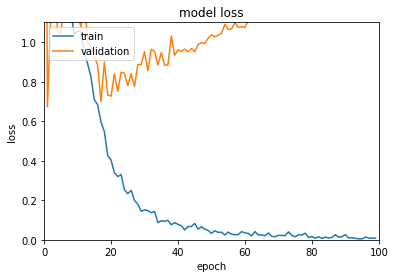

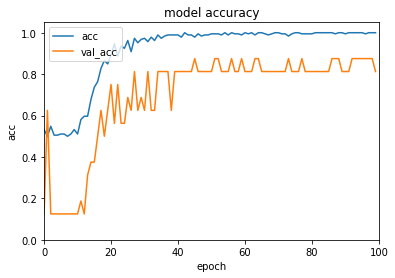

[[13  1]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


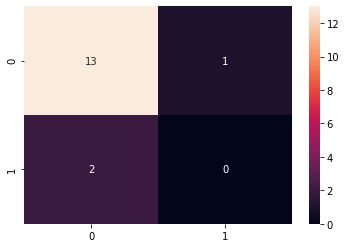

In [9]:
p2, t2 = run_model(2)

Train on 188 samples, validate on 16 samples
Epoch 1/100
188/188 [==============================] - 5s 27ms/step - loss: 3.6019 - acc: 0.4840 - val_loss: 3.1373 - val_acc: 0.1875
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 1.5484 - acc: 0.5053 - val_loss: 0.8189 - val_acc: 0.3125
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 1.3599 - acc: 0.5213 - val_loss: 1.1752 - val_acc: 0.1875
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2244 - acc: 0.5053 - val_loss: 1.3783 - val_acc: 0.1875
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2166 - acc: 0.5160 - val_loss: 1.2005 - val_acc: 0.1875
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 1.1459 - acc: 0.5372 - val_loss: 1.1133 - val_acc: 0.1875
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 1.1806 - acc: 0.5532 - val_loss: 1.2471 - val_acc: 0.1875
Epoch 8/100
188/188 [==

Epoch 62/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0587 - acc: 0.9894 - val_loss: 0.9554 - val_acc: 0.8125
Epoch 63/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0406 - acc: 0.9947 - val_loss: 0.9588 - val_acc: 0.8125
Epoch 64/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0263 - acc: 1.0000 - val_loss: 0.9008 - val_acc: 0.8125
Epoch 65/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0334 - acc: 0.9947 - val_loss: 0.9310 - val_acc: 0.8125
Epoch 66/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0268 - acc: 0.9947 - val_loss: 0.9698 - val_acc: 0.8125
Epoch 67/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0420 - acc: 0.9947 - val_loss: 0.9981 - val_acc: 0.8125
Epoch 68/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0587 - acc: 0.9947 - val_loss: 0.9910 - val_acc: 0.8125
Epoch 69/100
188/188 [==============================] - 0s 1ms

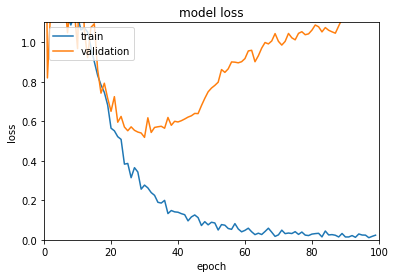

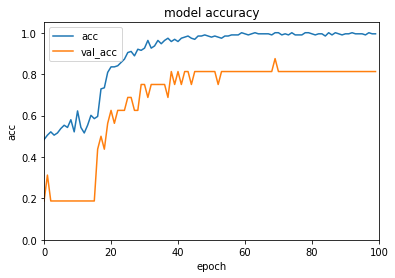

[[12  1]
 [ 2  1]]
PPV:  0.5
Recall:  0.3333333333333333


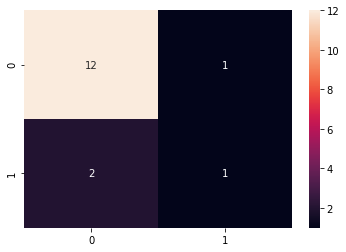

In [10]:
p3, t3 = run_model(3)

Train on 188 samples, validate on 16 samples
Epoch 1/100
188/188 [==============================] - 5s 26ms/step - loss: 3.2758 - acc: 0.5319 - val_loss: 4.0461 - val_acc: 0.1875
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 1.8515 - acc: 0.5053 - val_loss: 0.8729 - val_acc: 0.2500
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2582 - acc: 0.5372 - val_loss: 1.2414 - val_acc: 0.1875
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2392 - acc: 0.5053 - val_loss: 1.2794 - val_acc: 0.1875
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 1.1843 - acc: 0.5319 - val_loss: 0.9676 - val_acc: 0.1875
Epoch 6/100
188/188 [==============================] - 0s 2ms/step - loss: 1.2121 - acc: 0.5106 - val_loss: 1.0790 - val_acc: 0.1875
Epoch 7/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2200 - acc: 0.5106 - val_loss: 1.1094 - val_acc: 0.1875
Epoch 8/100
188/188 [==

188/188 [==============================] - 0s 2ms/step - loss: 0.0490 - acc: 0.9840 - val_loss: 0.5309 - val_acc: 0.8750
Epoch 62/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0345 - acc: 1.0000 - val_loss: 0.5163 - val_acc: 0.8750
Epoch 63/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0331 - acc: 0.9894 - val_loss: 0.5117 - val_acc: 0.8750
Epoch 64/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0428 - acc: 0.9894 - val_loss: 0.4986 - val_acc: 0.8750
Epoch 65/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0293 - acc: 0.9947 - val_loss: 0.4933 - val_acc: 0.8750
Epoch 66/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0386 - acc: 1.0000 - val_loss: 0.5186 - val_acc: 0.8750
Epoch 67/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0291 - acc: 0.9947 - val_loss: 0.5573 - val_acc: 0.8750
Epoch 68/100
188/188 [==============================] - 0s 1ms/step - loss:

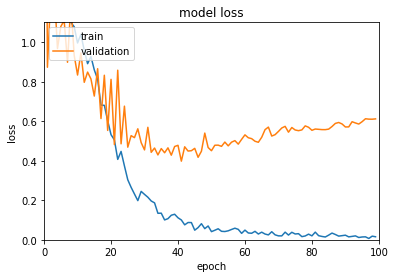

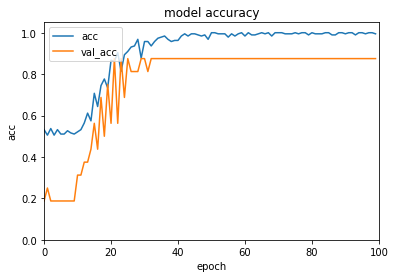

[[12  1]
 [ 1  2]]
PPV:  0.6666666666666666
Recall:  0.6666666666666666


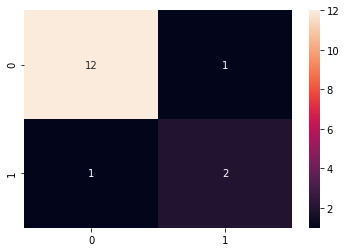

In [11]:
p4, t4 = run_model(4)

Train on 188 samples, validate on 16 samples
Epoch 1/100
188/188 [==============================] - 6s 30ms/step - loss: 2.8855 - acc: 0.5798 - val_loss: 3.7458 - val_acc: 0.2500
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 1.7835 - acc: 0.5106 - val_loss: 0.6043 - val_acc: 0.5625
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 1.4905 - acc: 0.5000 - val_loss: 1.1888 - val_acc: 0.2500
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 1.2511 - acc: 0.5000 - val_loss: 1.2893 - val_acc: 0.1875
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2042 - acc: 0.5000 - val_loss: 0.9829 - val_acc: 0.1875
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2727 - acc: 0.5053 - val_loss: 1.0228 - val_acc: 0.1875
Epoch 7/100
188/188 [==============================] - 0s 2ms/step - loss: 1.1738 - acc: 0.4947 - val_loss: 1.1328 - val_acc: 0.1875
Epoch 8/100
188/188 [==

Epoch 62/100
188/188 [==============================] - 0s 899us/step - loss: 0.0527 - acc: 0.9894 - val_loss: 0.9476 - val_acc: 0.7500
Epoch 63/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0524 - acc: 0.9894 - val_loss: 0.9430 - val_acc: 0.7500
Epoch 64/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0399 - acc: 0.9947 - val_loss: 0.8705 - val_acc: 0.7500
Epoch 65/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0614 - acc: 0.9787 - val_loss: 0.9309 - val_acc: 0.7500
Epoch 66/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0421 - acc: 0.9894 - val_loss: 0.9782 - val_acc: 0.7500
Epoch 67/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0378 - acc: 1.0000 - val_loss: 0.9249 - val_acc: 0.7500
Epoch 68/100
188/188 [==============================] - 0s 1ms/step - loss: 0.0606 - acc: 0.9840 - val_loss: 0.8336 - val_acc: 0.7500
Epoch 69/100
188/188 [==============================] - 0s 1

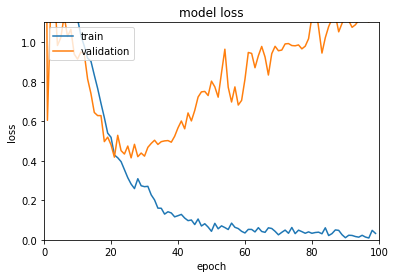

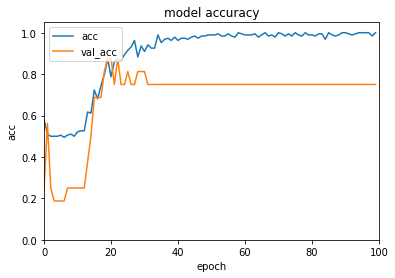

[[12  1]
 [ 3  0]]
PPV:  0.0
Recall:  0.0


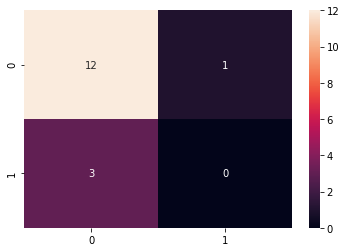

In [12]:
p5, t5 = run_model(5)

In [ ]:
p6, t6 = run_model(6)

Train on 188 samples, validate on 16 samples
Epoch 1/100
188/188 [==============================] - 6s 30ms/step - loss: 3.0418 - acc: 0.5691 - val_loss: 2.8910 - val_acc: 0.1875
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 1.4713 - acc: 0.5426 - val_loss: 0.7421 - val_acc: 0.5000
Epoch 3/100
188/188 [==============================] - 0s 899us/step - loss: 1.2835 - acc: 0.5106 - val_loss: 1.5656 - val_acc: 0.1875
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2132 - acc: 0.5053 - val_loss: 1.1834 - val_acc: 0.1875
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 1.2523 - acc: 0.5160 - val_loss: 1.0256 - val_acc: 0.1875
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 1.1460 - acc: 0.5213 - val_loss: 1.3825 - val_acc: 0.1875
Epoch 7/100
188/188 [==============================] - 0s 953us/step - loss: 1.1236 - acc: 0.5213 - val_loss: 0.9481 - val_acc: 0.2500
Epoch 8/100
188/188

188/188 [==============================] - 0s 2ms/step - loss: 0.0849 - acc: 0.9787 - val_loss: 0.3498 - val_acc: 0.8125
Epoch 46/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0615 - acc: 0.9894 - val_loss: 0.3363 - val_acc: 0.8125
Epoch 47/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0514 - acc: 0.9894 - val_loss: 0.3609 - val_acc: 0.8125
Epoch 48/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0653 - acc: 0.9894 - val_loss: 0.3351 - val_acc: 0.7500
Epoch 49/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0608 - acc: 0.9787 - val_loss: 0.3866 - val_acc: 0.8125
Epoch 50/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0812 - acc: 0.9840 - val_loss: 0.3869 - val_acc: 0.8125
Epoch 51/100
188/188 [==============================] - 0s 2ms/step - loss: 0.0467 - acc: 1.0000 - val_loss: 0.2953 - val_acc: 0.8125
Epoch 52/100
188/188 [==============================] - 0s 2ms/step - loss:

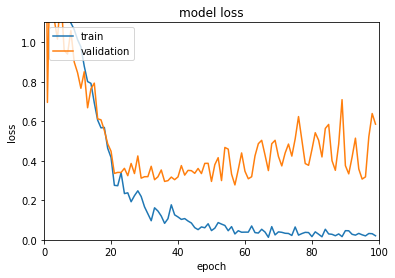

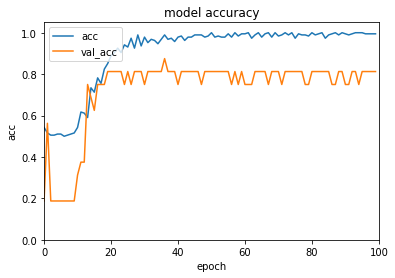

[[13  0]
 [ 3  0]]


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV:  0.0
Recall:  0.0


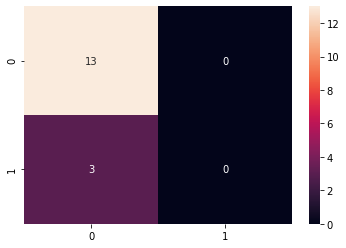

In [14]:
p7, t7 = run_model(7)

Positive Predictive Value tp/(tp+fp):  0.4444444444444444
Recall Value tp/(tp+fn):  0.18181818181818182
[[102   5]
 [ 18   4]]


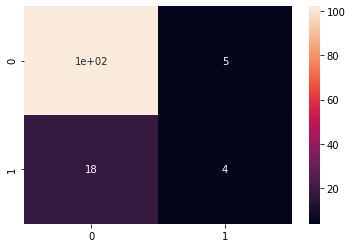

In [15]:
create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7)